# Importing Libraries

In [ ]:
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel,AutoTokenizer
from tqdm import tqdm
import evaluate
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.utils import shuffle
from torchmetrics.classification import BinaryAccuracy,BinaryConfusionMatrix,BinaryF1Score,BinaryPrecision,BinaryRecall, MulticlassPrecision,MulticlassRecall,MulticlassF1Score
from torchmetrics.collections import MetricCollection
from google.colab import userdata
import neptune
import neptune.integrations.optuna as npt_utils
from neptune.types import File
import time

# Setting up the GPU or CPU

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

# Define Variable Values

In [ ]:
# @title Define Transformer Model Name
bert_model_name = "vinai/bertweet-base" # @param {type:"string"}

In [ ]:
# @title Define Hugging Face Dataset Name
dataset_name = "krishan-CSE/Davidson_Hate_Speeh_and_Emotion" # @param {type:"string"}

In [ ]:
#@title Define Transformer Model Tokenizer Max Padding Length
SEED = 1234
PADDING_MAX_LENGTH = 45 # @param {type:"integer"}

#Configuring Neptuna

In [ ]:
# @title Define Neptuna Project Name,Study ID and Best Trial ID
study_id = "FYPTHUS-1455" # @param {type:"string"}
trial_id = "FYPTHUS-1497" # @param {type:"string"}
project_name='FYP-DCL/fyp-thushalya'# @param {type:"string"}

In [ ]:
# @title Define Neptuna DCL Project Name & Study Id
dcl_study_id='DCLNEWDV-178' # @param {type:"string"}
best_trial_id='DCLNEWDV-219' # @param {type:"string"}
dcl_project_name='pasansk/DCL-NEWDV'# @param {type:"string"}

##Load the Study Run

In [ ]:
run_study = neptune.init_run(with_id=study_id,project=project_name)

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-1455


## Load the Best Trial Run

In [ ]:
run_trial = neptune.init_run(with_id=trial_id,project=project_name)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-1497


In [ ]:
best_prams=run_trial["parameters"].fetch()

# Setting Random Seed for Reproducibility

In [ ]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


In [ ]:
setup_seed(SEED)

# Loading Test Dataset

In [ ]:
dataset = load_dataset(dataset_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 18586
    })
    test: Dataset({
        features: ['text', 'labels', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6196
    })
})

# Loading the Tokernizer for the Transformer Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


##Define the Tokenizer Function

In [ ]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
# Define a function to merge columns into a list
def merge_emotion_columns_to_list(example):
    return {'emotion_vector': [example['anger'], example['anticipation'], example['disgust'],example['fear'],example['joy'],example['love'],example['optimism'],example['pessimism'],example['sadness'],example['surprise'],example['trust']]}

# Apply the function to each example in the dataset
tokenized_datasets = tokenized_datasets.map(merge_emotion_columns_to_list)

## Remove Unwanted Coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.remove_columns(['text','anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])

## Format the coloumns

In [ ]:
tokenized_datasets=tokenized_datasets.with_format("torch")

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask', 'emotion_vector'],
        num_rows: 18586
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask', 'emotion_vector'],
        num_rows: 6196
    })
})

# Creating DataLoaders for Train & Test Datasets

In [ ]:
train_dataloader=DataLoader(tokenized_datasets["train"], batch_size=best_prams["BATCH_SIZE"] , shuffle=False)

In [ ]:
test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=best_prams["BATCH_SIZE"] , shuffle=False)

# Define the Dual Contrastive Learning Architecture

In [ ]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]
        torch.cuda.empty_cache()

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

## Define Focal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha:float=0.4, gamma:float=2, size_average:bool=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, pred, target):

        device = target.device
        self.alpha = self.alpha.to(device)

        pred = nn.Sigmoid()(pred)
        pred = pred.view(-1, 1)
        target = target.view(-1, 1)
        pred = torch.cat((1-pred, pred), dim=1)

        class_mask = torch.zeros(pred.shape[0], pred.shape[1]).to(device)
        class_mask.scatter_(1, target.view(-1, 1).long(), 1.)
        probs = (pred * class_mask).sum(dim=1).view(-1, 1)
        probs = probs.clamp(min=0.0001, max=1.0)

        log_p = probs.log()
        alpha = torch.ones(pred.shape[0], pred.shape[1]).to(device)
        alpha[:, 0] = alpha[:, 0] * (1 - self.alpha)
        alpha[:, 1] = alpha[:, 1] * self.alpha
        alpha = (alpha * class_mask).sum(dim=1).view(-1, 1)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

In [ ]:
class EmotionGuidedDCLModel(nn.Module):
    def __init__(self,dcl_model:nn.Module,dropout:float=0.25):
        super(EmotionGuidedDCLModel, self).__init__()
        self.dcl_model = dcl_model
        self.dim = 779
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.dim, 1)
        # Freeze all layers
        for param in self.dcl_model.parameters():
            param.requires_grad = False

    def forward(self,batch_tokenized):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        emotion_vector = batch_tokenized['emotion_vector']
        bert_output = self.dcl_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]
        combined_vector =torch.cat((bert_cls_hidden_state,emotion_vector), 1)
        d_combined_vector=self.dropout(combined_vector)
        linear_output = self.linear(d_combined_vector)
        pred_linear = linear_output.squeeze(1)
        return pred_linear

#Configuring the Model & Focal Loss

In [ ]:
run_dcl_study = neptune.init_run(with_id=dcl_study_id,project=dcl_project_name,mode='read-only')

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pasansk/DCL-NEWDV/e/DCLNEWDV-178


In [ ]:
run_best_model_trial = neptune.init_run(with_id=best_trial_id,project=dcl_project_name,mode="read-only")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pasansk/DCL-NEWDV/e/DCLNEWDV-219


In [ ]:
best_prams=run_best_model_trial["parameters"].fetch()

In [ ]:
def load_checkpoint(run: neptune.Run,check_point_name:str):
    model_ext = run[check_point_name]["model"].fetch_extension()
    run[check_point_name]["model"].download()  # Download the checkpoint
    run.wait()
    # Load the checkpoint
    checkpoint = {
        "model_state_dict":torch.load(f"model.{model_ext}"),
    }
    return checkpoint

In [ ]:
checkpoint=load_checkpoint(run=run_dcl_study,check_point_name="model_checkpoints/")

Fetching file...: 0 [00:00, ?/s]

In [ ]:
dcl_model = DCLArchitecture(bert_model_name=bert_model_name,dropout=best_prams["DROPOUT"])
dcl_model.to(device)

DCLArchitecture(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [ ]:
dcl_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
run_dcl_study.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/pasansk/DCL-NEWDV/e/DCLNEWDV-178/metadata


In [ ]:
run_best_model_trial.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/pasansk/DCL-NEWDV/e/DCLNEWDV-219/metadata


In [ ]:
fined_tuned_bert_model=dcl_model.bert

In [ ]:
DROPOUT = 0.5
model = EmotionGuidedDCLModel(dcl_model=fined_tuned_bert_model,dropout=DROPOUT)
model.to(device)

EmotionGuidedDCLModel(
  (dcl_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr = best_prams["LEARNING_RATE"])

In [ ]:
criteon = FocalLoss(best_prams["ALPHA"],best_prams["GAMMA"])

#Training the Model

## Define Training Loop

In [ ]:
def training_loop(model, train_dataloader,optimizer,criteon,device):
    accuracy_metric = BinaryAccuracy()
    accuracy_metric.to(device)
    progress_bar = tqdm(range(len(train_dataloader)))
    model.train()
    total_train_loss = 0.0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        pred = model(batch)
        loss = criteon(pred, labels.float())
        total_train_loss += loss.item()
        loss_value=loss.item()
        pred_sig = torch.sigmoid(pred)
        preds_detach=torch.round(pred_sig.detach())
        accuracy_metric(preds_detach,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    average_epoch_train_loss = total_train_loss / len(train_dataloader)  # Compute average epoch loss
    train_accuracy =  accuracy_metric.compute()
    accuracy_metric.reset()
    return average_epoch_train_loss,train_accuracy.item()

##Training

In [ ]:
for epoch in range(best_prams["EPOCHS"]):
        start_time = time.time()
        average_epoch_train_loss,train_accuracy = training_loop(model, train_dataloader,optimizer,criteon,device)
        end_time = time.time()

        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {average_epoch_train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0.0m 42.66s
	Train Loss: 0.033 | Train Acc: 86.82%


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0.0m 43.16s
	Train Loss: 0.021 | Train Acc: 94.25%


# Evaluate with Test Dataset

In [ ]:
def test_loop(model, test_dataloader,criteon, device,average:str="macro"):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
    )
    collection_metric.to(device)
    bcm_metric = BinaryConfusionMatrix()
    bcm_metric.to(device)
    model.eval()
    total_test_loss = 0.0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        with torch.no_grad():
            pred = model(batch)
            loss = criteon(pred, labels.float())
            pred = torch.round(torch.sigmoid(pred))
        total_test_loss += loss.item()
        collection_metric(pred,labels)
        bcm_metric(pred,labels)
    average_epoch_test_loss = total_test_loss / len(test_dataloader)  # Compute average epoch loss
    result =  collection_metric.compute()
    bcm_metric.compute()
    collection_metric.reset()
    result['Loss']=average_epoch_test_loss
    result['confustion_matrix'],_=bcm_metric.plot()
    bcm_metric.reset()
    return result

## Test the model with Test Set

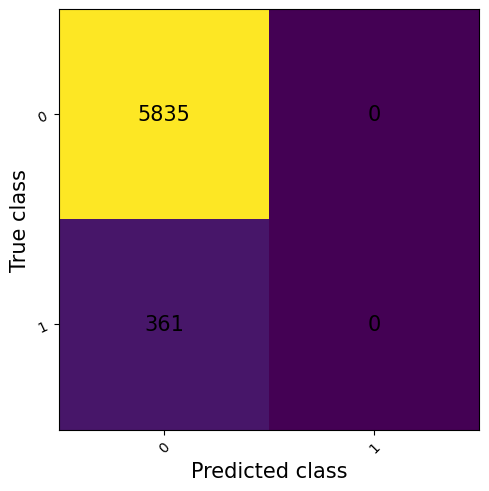

In [ ]:
result_metrics=test_loop(model, test_dataloader,criteon, device,average="weighted")

In [ ]:
result_metrics

{'BinaryAccuracy': tensor(0.9417, device='cuda:0'),
 'MulticlassPrecision': tensor(0.8869, device='cuda:0'),
 'MulticlassRecall': tensor(0.9417, device='cuda:0'),
 'MulticlassF1Score': tensor(0.9135, device='cuda:0'),
 'Loss': 0.01755078404960109,
 'confustion_matrix': <Figure size 640x480 with 1 Axes>}

## Upload the Test Results to Neptuna

In [ ]:
def upload_test_metrics(result,run: neptune.Run):
    run["Test_Result/Accuracy"]=result["BinaryAccuracy"]
    run["Test_Result/Loss"]=result["Loss"]
    run["Test_Result/weighted_Precision"]=result["MulticlassPrecision"]
    run["Test_Result/weighted_Recall"]=result["MulticlassRecall"]
    run["Test_Result/weighted_F1Score"]=result["MulticlassF1Score"]
    run["Test_Result/confustion_matrix"].upload(result["confustion_matrix"])
    run.wait()
    print("Upload Succesfull")


In [ ]:
upload_test_metrics(result_metrics,run_study)

Upload Succesfull


# Save the Model Checkpoint

In [ ]:
def save_model_states(model,criteon,optimizer):
    torch.save(model.state_dict(),'model.pt')
    torch.save(criteon.state_dict(),'criteon.pt')
    torch.save(optimizer.state_dict(),'optimizer.pt')

In [ ]:
def upload_model_checkpoint(directory:str,run: neptune.Run):
    run[f"{directory}/model"].upload('model.pt')
    run[f"{directory}/criteon"].upload('criteon.pt')
    run[f"{directory}/optimizer"].upload('optimizer.pt')
    run.wait()

In [ ]:
save_model_states(model=model,criteon=criteon,optimizer=optimizer)
upload_model_checkpoint(run=run_study,directory="model_checkpoints")

In [ ]:
run_trial.stop()
run_study.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-1497/metadata
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/FYP-DCL/fyp-thushalya/e/FYPTHUS-1455/metadata
